This notebook simulates dips in brightness of varying depths compared to the median magnitude of historic data from the ZTF archive. 

In [1]:
%matplotlib inline
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

from lasairmod import LasairError, lasair_client as lasair
import sys, time
import json
import scipy
from sympy import *
from ztfquery import lightcurve, query, metasearch
import scipy.stats as st
from scipy.stats import ks_2samp

/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def diff_to_app_mag(ref_mag, alert_mag, sign): 
   
    """Function converts from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    alert_mag : float
        Difference magnitude of alert.
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
        

    Returns
    -------
    app_mag
        Apparent magnitude as type ``float``.
    
    """
    if sign =='t': 
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) + (10**((-.4)*alert_mag)),10))
    else:
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) - (10**((-.4)*alert_mag)),10)) 
    
    return float(app_mag)

In [3]:
def app_mag_err_prop(ref_mag, alert_mag, sign, ref_err, alert_err):
    
    """Function propagates error when converting from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    
    alert_mag : float
        Difference magnitude of alert.
    
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
    
    ref_err : float
        1-sigma uncertainty in reference magnitude.
   
    alert_err : float
        1-sigma uncertainty in alert magnitude.
        

    Returns
    -------
    app_err
        Apparent magnitude error as type ``float``.
    
    """
    
    
    r, a= symbols('r a', real=True) # Defines variables r (reference mag) and a (alert mag)
    
    if sign =='t': 
        f = ((-2.5)*log((10**((-.4)*r)) + (10**((-.4)*a)),10))
    else:
        f = ((-2.5)*log((10**((-.4)*r)) - (10**((-.4)*a)),10)) 
    
    
    # f = diff_to_app_mag(ref_mag, alert_mag, sign)
    
    d_ref = diff(f, r).subs([(a, alert_mag), (r, ref_mag)])         # Partial derivative of f with respect to r
    d_alert = diff(f, a).subs([(a, alert_mag), (r, ref_mag)])       # Partial derivative of f with respect to a
    
    app_err = float(sqrt((((d_ref)**2)*((ref_err)**2))+(((d_alert)**2)*((alert_err)**2))))   # Error propagation formula
    
    return app_err

In [4]:
def random(median, std, size):
    
    """Function generates array of random numbers of specified median, standard deviation, and size. 
    
    Parameters
    ----------
    median : float
        Desired median of random array.
    
    std : float
        Desired standard deviation of array.
    
    size : int
        Desired lenth of array. 
        

    Returns
    -------
    shifted_numbers : array
        Random numbers as type ``array``.
    
    """
    # Generate random numbers from a standard normal distribution
    random_numbers = np.random.randn(size)
    
    # Calculate the current standard deviation of the generated numbers
    current_std = np.std(random_numbers)
    
    # Scale to match desired standard deviation
    scaled_numbers = random_numbers * (std / current_std)
    
    # Calculate the current median fo the scaled numbers
    current_median = np.median(scaled_numbers)
    
    # Shift to match desired median
    shifted_numbers = scaled_numbers - current_median + median
    
    
    return shifted_numbers


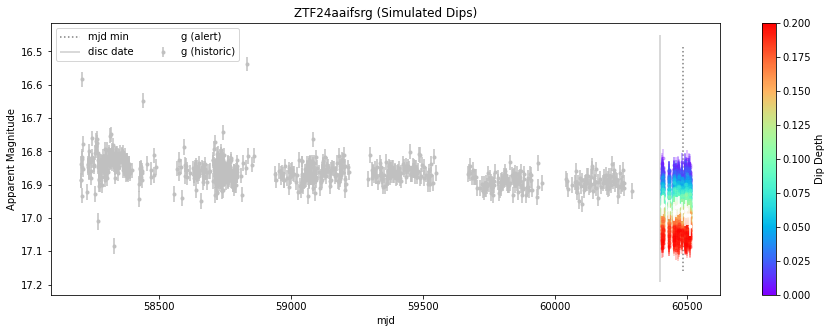

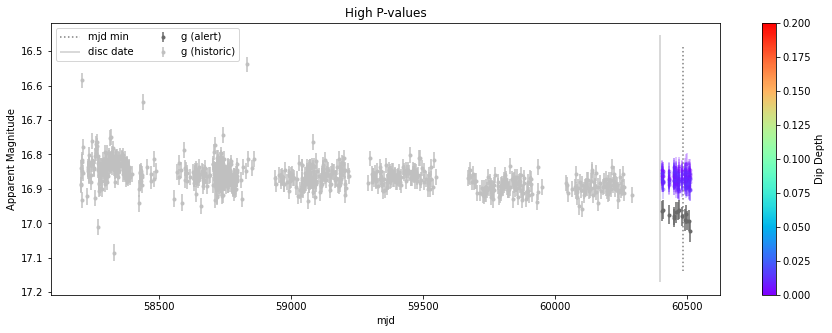

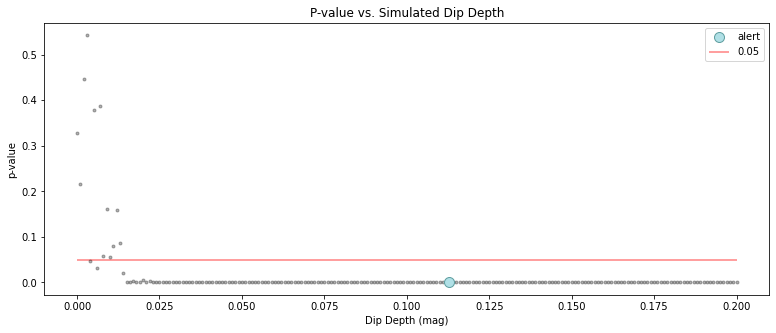

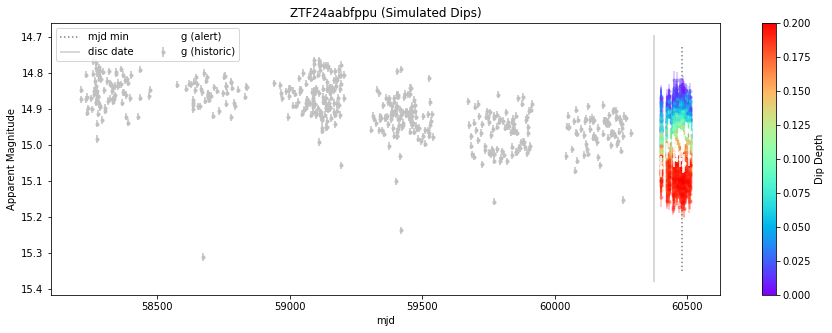

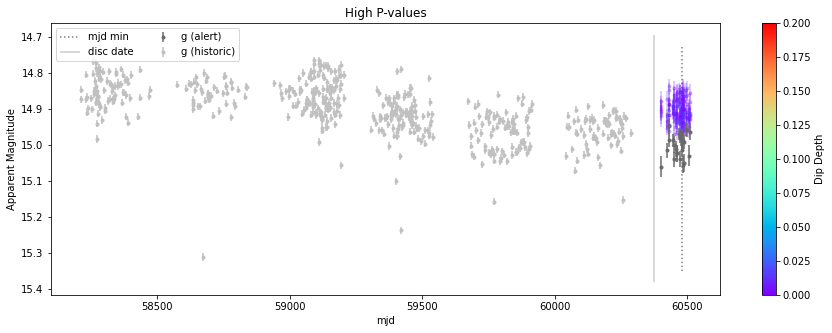

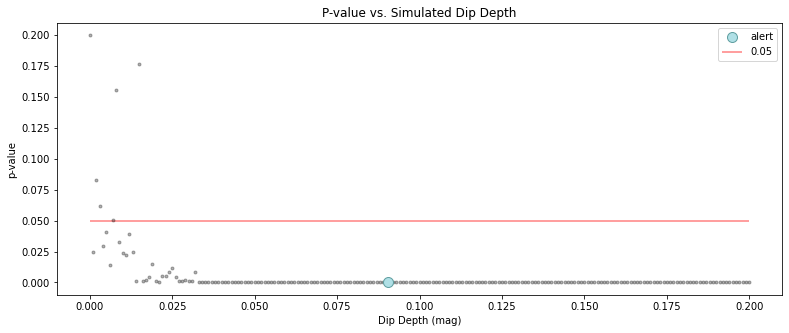

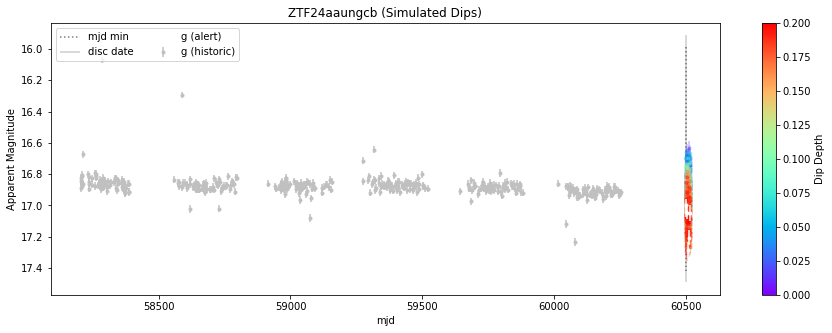

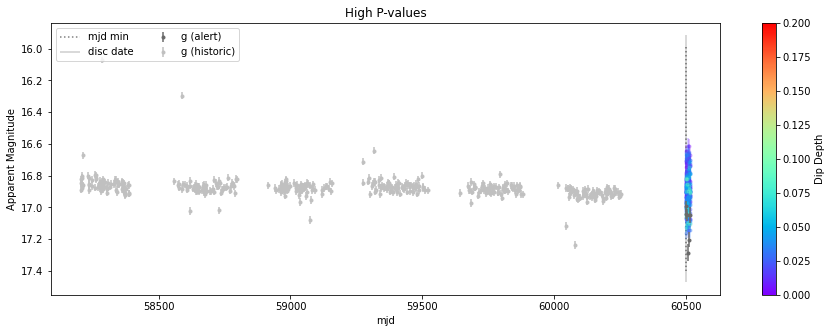

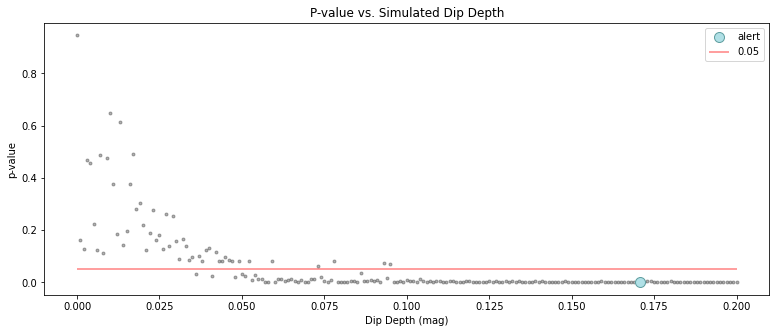

In [33]:
L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")
ZTF24aaifsrg = L.objects(['ZTF24aaifsrg', 'ZTF24aabfppu', 'ZTF24aaungcb'])           
lc = {}
candidates = []
trash = []

for obj in ZTF24aaifsrg:
    try:
        lc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')
    
    # Pulling historic ZTF light curve
    ztf = lightcurve.LCQuery.from_position(obj['objectData']['ramean'], obj['objectData']['decmean'], 1)
    
    # Defining arrays of ZTF historic g-band magnitudes 
    ztf_gsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])

    # same for magnitude errors
    ztf_gerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])

    # ...and dates
    ztf_gmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # Creating empty lists for each ZTF filter-band to be filled with apparent magnitudes and errors
    gmag = []
    gerr = []
    gmjd = []

    
    for i in lc[obj['objectId']]['candidates']:
        if 'isdiffpos' in i:
            app_mag = diff_to_app_mag(i['magnr'], i['magpsf'], i['isdiffpos']) # calculating apparent magnitude 
            app_err = app_mag_err_prop(i['magnr'], i['magpsf'], i['isdiffpos'], i['sigmagnr'], i['sigmapsf']) # propagating error
            
            # appending magnitudes and errors in g filter to their respective lists
            if i['fid']== 1:
                gmag.append(app_mag)
                gerr.append(app_err)
                gmjd.append(i['mjd'])
    
    
    # Converting list of alert packet magnitudes to array
    alert_gsamp = np.array(gmag)
    
    # Performing K-S test with 95% confidence interval for g filter
    if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
        KS_g = st.ks_2samp(alert_gsamp, ztf_gsamp)
    
     # Calculating Chi Square statistics for g filter
    if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
         chisq_g = np.sum((((ztf_gsamp - np.median(ztf_gsamp)) / ztf_gerr)**2 ) / float(len(ztf_gsamp)))
  

    # Plotting
    fig, ax = plt.subplots(figsize = (15, 5))
    plt.subplot(111)

    # Alert data
    ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'white', label = 'g (alert)', zorder=2)

    # Historic data
    gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'silver', label = 'g (historic)', zorder= 1)
    
    # Simulating Dips
    depths = np.arange(0, .2001, 0.001)  #creating array of dip depths 
    medians = np.median(ztf_gsamp) + depths #creating array of medians for simulating dips
    cmap = plt.cm.rainbow #defining color map
    norm = plt.Normalize(vmin=np.min(depths), vmax=np.max(depths)) #normalizing data
    p = [] #p-values for simulated dips
    
    for i, j in zip(medians, depths):
        dip = random(i, np.std(gmag), len(gmag)) #generating simulated dips
        color = cmap(norm(j)) 
        plt.errorbar(gmjd, dip, yerr = gerr, fmt = '.', alpha = 0.3, zorder= -50, c= color) #plotting dips
        KS = st.ks_2samp(dip, ztf_gsamp) #performing K-S test on simulated dips
        p.append(KS.pvalue)
        #print((obj['objectId']+' K-S result with median '+ str(i) + ': ' + str(KS)))

    mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='black', linestyles=':', alpha=0.5, zorder=-100, label='mjd min')  
    disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='black', alpha=0.2, zorder=-99, label='disc date')
    plt.gca().invert_yaxis()
    plt.ylabel('Apparent Magnitude')
    plt.xlabel('mjd')
    plt.title(obj['objectId']+' (Simulated Dips)')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    plt.colorbar(sm, ax=ax, label='Dip Depth')
    plt.legend(loc= 'upper left', ncol=2)
    plt.show()
    
    

    
    
     # Plotting only high p-values
    fig, ax = plt.subplots(figsize = (15, 5))
    plt.subplot(111)

    # Alert data
    ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'dimgray', label = 'g (alert)', zorder=2)

    # Historic data
    gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'silver', label = 'g (historic)', zorder= 1)
    
    # Simulating Dips
    depths = np.arange(0, .2001, 0.001)  #creating array of dip depths 
    medians = np.median(ztf_gsamp) + depths #creating array of medians for simulating dips
    cmap = plt.cm.rainbow #defining color map
    norm = plt.Normalize(vmin=np.min(depths), vmax=np.max(depths)) #normalizing data
    p = [] #p-values for simulated dips
    
    for i, j in zip(medians, depths):
        dip = random(i, np.std(gmag), len(gmag)) #generating simulated dips
        color = cmap(norm(j)) 
        KS = st.ks_2samp(dip, ztf_gsamp) #performing K-S test on simulated dips
        p.append(KS.pvalue)
        
        if KS.pvalue > 0.05:
            plt.errorbar(gmjd, dip, yerr = gerr, fmt = '.', alpha = 0.3, zorder= -50, c= color) #plotting dips
        #print((obj['objectId']+' K-S result with median '+ str(i) + ': ' + str(KS)))

    mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='black', linestyles=':', alpha=0.5, zorder=-100, label='mjd min')  
    disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='black', alpha=0.2, zorder=-99, label='disc date')
    plt.gca().invert_yaxis()
    plt.ylabel('Apparent Magnitude')
    plt.xlabel('mjd')
    plt.title('High P-values')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    plt.colorbar(sm, ax=ax, label='Dip Depth')
    plt.legend(loc= 'upper left', ncol=2)
    plt.show()
    
    
    
    
    
    #Plotting P-value vs. Dip Depth
    plt.figure(figsize= (13, 5) )
    plt.plot(depths, p, '.', color='black', alpha= 0.3)
    plt.plot(np.median(gmag)- np.median(ztf_gsamp), KS_g.pvalue, 'o', c= 'powderblue', markeredgecolor='cadetblue', markersize= 10, zorder=2, label='alert')
    plt.hlines(0.05, np.min(depths), np.max(depths), color='r', zorder=-1, alpha= 0.5, label='0.05')
    plt.ylabel('p-value')
    plt.xlabel('Dip Depth (mag)')
    plt.title('P-value vs. Simulated Dip Depth')
    plt.legend()
    plt.show()
  